## Modelisation with UNET VGG16

In [1]:
import sys  
sys.path.insert(0, './scripts')

# Import librairies, configs, helper functions
from helpers import *

config = base_config

# config["use_saved_model_path"] = "./model_delete.keras"
# config["val_sample_nb"] = 100
# config["train_sample_nb"] = 400
# config["max_evals"] = 10
config["mlwflow_experiment_title"] = "UNET VGG16 - Augmented"

n = NotebookProcessor(config)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


{
    "width": 512,
    "height": 256,
    "classes": 8,
    "use_augment": true,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET VGG16 - Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


## Model definition

This model adopts the UNet architecture utilizing VGG16 pretrained on ImageNet as its encoder for advanced feature extraction. 

The contracting path is powered by VGG16, capturing in-depth image details, while the expansive path ensures precise localization by upsampling. Skip connections between VGG16's layers and the decoder maintain spatial information. The integration of VGG16 enriches the model's ability to handle complex image segmentation tasks efficiently.  

Here we start at 64 filters all the way to 512 and back to 64

## Model creation

In [2]:
def conv_block(input_tensor, num_filters, dropout_rate=0.1):  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    x = Dropout(dropout_rate)(x)  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    return x  
  
def create_model(n_classes, img_width, img_height, img_channels):    
    # Load VGG16 as the encoder with pretrained ImageNet weights  
    base_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, img_channels))  
      
    # Freeze the layers of VGG16  
    for layer in base_vgg16.layers:  
        layer.trainable = False  
      
    # Encoder - take the outputs of the VGG16 layers to create the contracting path  
    s1 = base_vgg16.get_layer("block1_conv2").output  # 64 filters  
    s2 = base_vgg16.get_layer("block2_conv2").output  # 128 filters  
    s3 = base_vgg16.get_layer("block3_conv3").output  # 256 filters  
    s4 = base_vgg16.get_layer("block4_conv3").output  # 512 filters  
    c5 = base_vgg16.get_layer("block5_conv3").output  # 512 filters, this acts as the bridge  
  
    # Start from bottom and go up, using U-Net's expansive path  
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)    
    u6 = concatenate([u6, s4])    
    c6 = conv_block(u6, 512)   
      
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)    
    u7 = concatenate([u7, s3])    
    c7 = conv_block(u7, 256)    
      
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)    
    u8 = concatenate([u8, s2])    
    c8 = conv_block(u8, 128)    
      
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)    
    u9 = concatenate([u9, s1])    
    c9 = conv_block(u9, 64)    
  
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)    
      
    model = Model(inputs=[base_vgg16.input], outputs=[outputs])  
      
    return model  

## Model Stats

### With augment

2024-03-02 00:12:58.175867: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-02 00:12:58.175887: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-03-02 00:12:58.175891: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-03-02 00:12:58.175941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-02 00:12:58.176118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


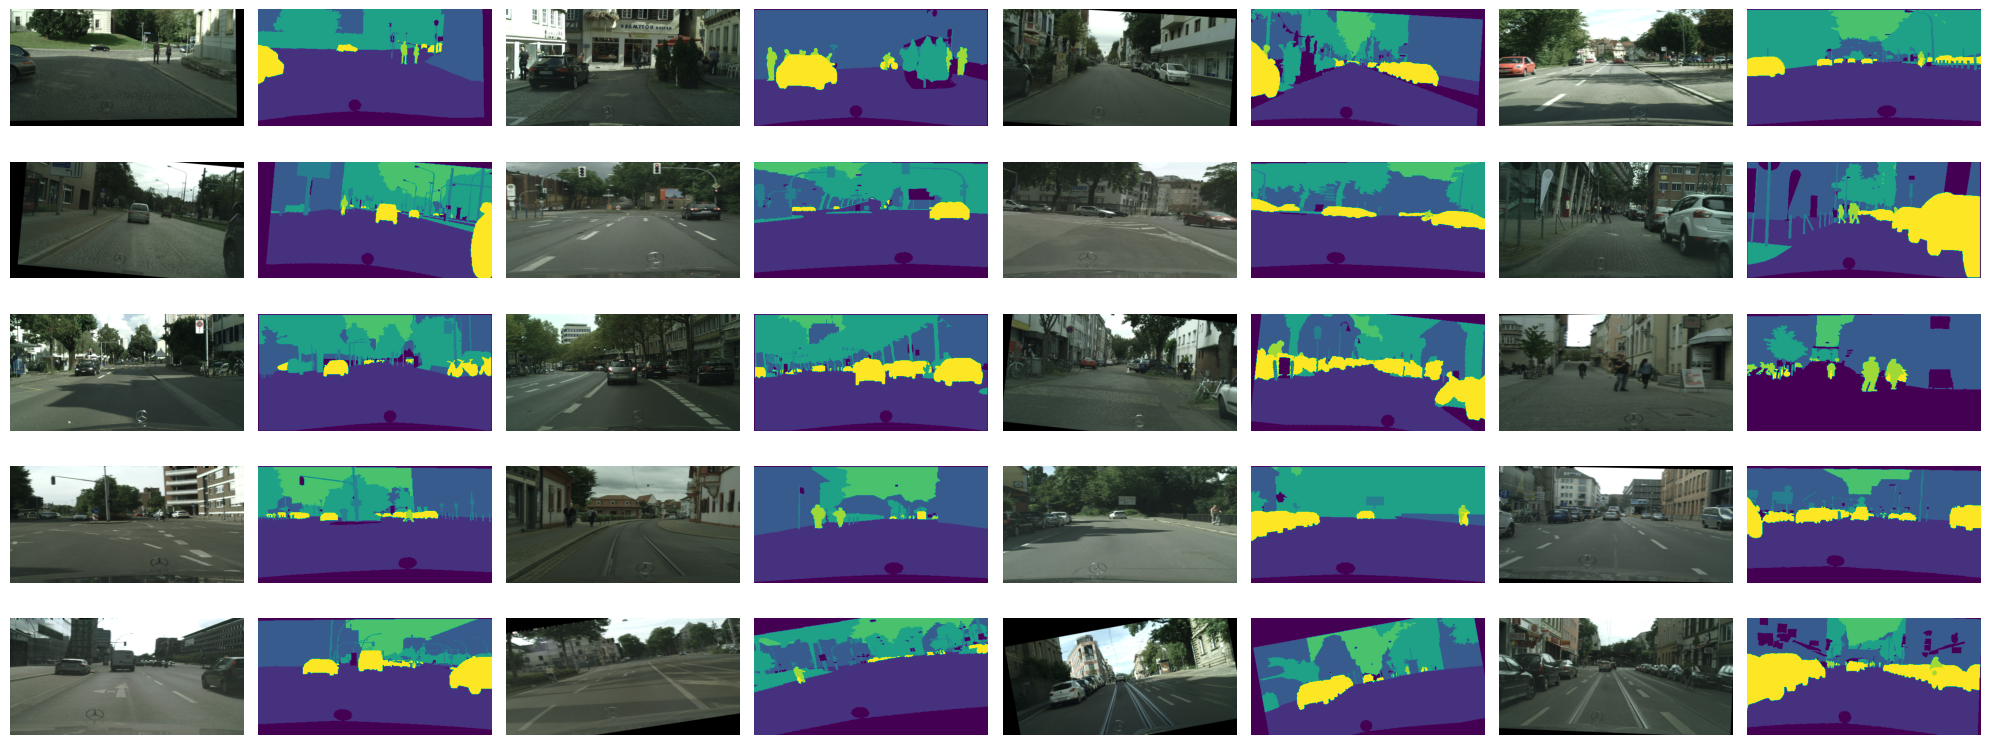

In [3]:
show_data_generator_images_sample(n)

In [4]:
model = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n.set_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 512, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 256, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [5]:
space = None
# space = {
#     'image_per_augment': hp.choice('image_per_augment', [1, 2, 3]),
#     'batch_size': hp.choice('batch_size', [3, 4, 5]),
#     'epochs': hp.choice('epochs', [4, 8, 12, 24]),
#     'learning_rate': hp.uniform('learning_rate', 0.0001, 0.001),  
# }
n.model_fit(space)

Epoch 1/12                                           

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024-03-02 00:13:04.845082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


991/991 [==============================] - 785s 791ms/step - loss: 0.5142 - dice_coef: 0.7627 - iou: 0.6240 - accuracy: 0.8409 - val_loss: 0.5633 - val_dice_coef: 0.7780 - val_iou: 0.6452 - val_accuracy: 0.8308

Epoch 2/12                                           

991/991 [==============================] - 844s 852ms/step - loss: 0.4002 - dice_coef: 0.8101 - iou: 0.6860 - accuracy: 0.8734 - val_loss: 0.5109 - val_dice_coef: 0.7653 - val_iou: 0.6259 - val_accuracy: 0.8358

Epoch 3/12                                           

991/991 [==============================] - 859s 867ms/step - loss: 0.3646 - dice_coef: 0.8257 - iou: 0.7079 - accuracy: 0.8841 - val_loss: 0.4756 - val_dice_coef: 0.8034 - val_iou: 0.6794 - val_accuracy: 0.8513

Epoch 4/12                                           

991/991 [==============================] - 867s 874ms/step - loss: 0.3415 - dice_coef: 0.8364 - iou: 0.7236 - accuracy: 0.8910 - val_loss: 0.4318 - val_dice_coef: 0.8045 - val_iou: 0.6808 - val_accur

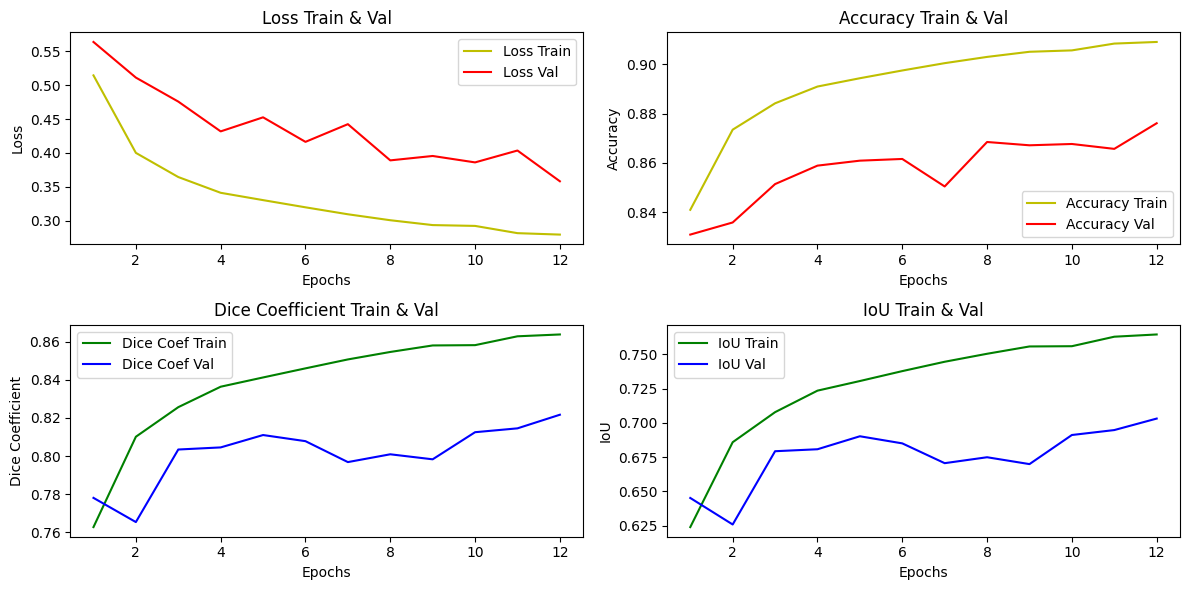

1/1 [==============================] - 0s 30ms/step


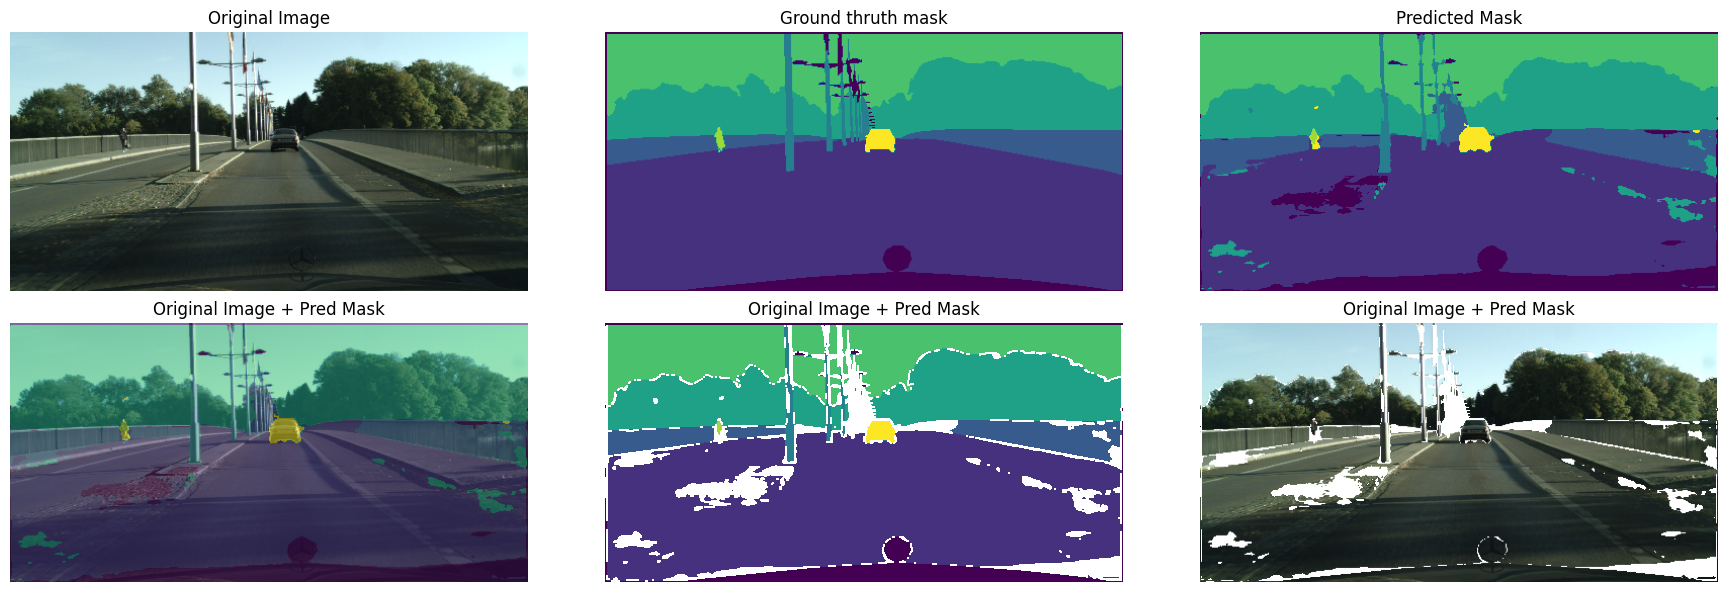

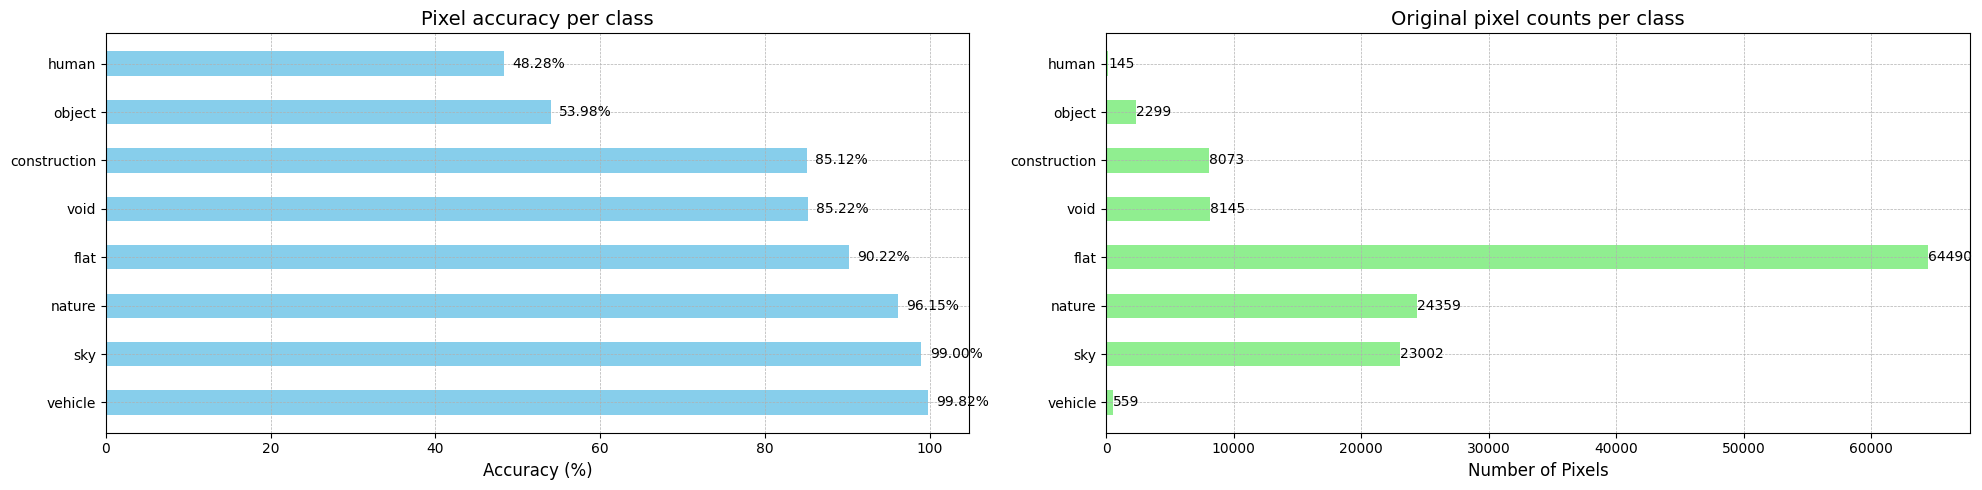

In [8]:
display_loss_accuracy_dice_iou(n.model_fit_history)
n.model_predict_with_display_and_accuracy(n.img["val"][0],n.mask["val"][0])

### Without augment

{
    "width": 512,
    "height": 256,
    "classes": 8,
    "use_augment": false,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET VGG16 - Not Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


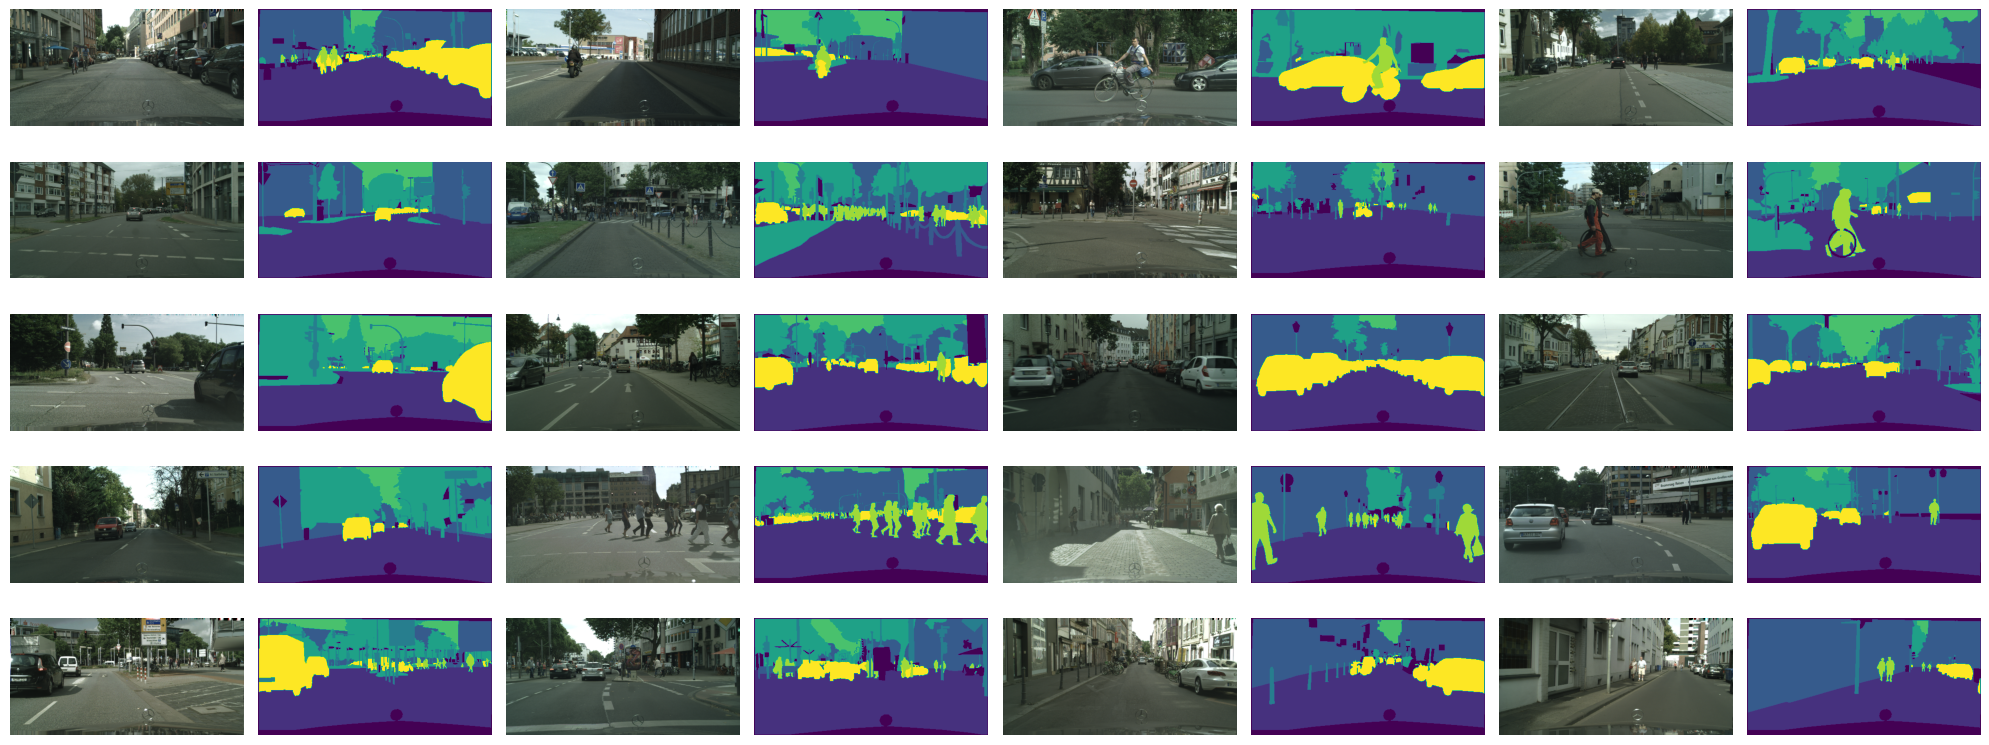

In [9]:
config_not_aug = {
    **config,
    "use_augment": False,
    "mlwflow_experiment_title":"UNET VGG16 - Not Augmented"

}

n_not_aug = NotebookProcessor(config_not_aug)
show_data_generator_images_sample(n_not_aug)

In [10]:
model_not_aug = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n_not_aug.set_model(model_not_aug)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 512, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 512, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 256, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [11]:
n_not_aug.model_fit(space)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024/03/02 10:33:51 INFO mlflow.tracking.fluent: Experiment with name 'UNET VGG16 - Not Augmented' does not exist. Creating a new experiment.



Epoch 1/12                                           

991/991 [==============================] - 932s 939ms/step - loss: 0.5119 - dice_coef: 0.7647 - iou: 0.6262 - accuracy: 0.8414 - val_loss: 0.6188 - val_dice_coef: 0.7619 - val_iou: 0.6251 - val_accuracy: 0.8137

Epoch 2/12                                           

991/991 [==============================] - 974s 983ms/step - loss: 0.3954 - dice_coef: 0.8120 - iou: 0.6887 - accuracy: 0.8743 - val_loss: 0.5264 - val_dice_coef: 0.7928 - val_iou: 0.6650 - val_accuracy: 0.8412

Epoch 3/12                                           

991/991 [==============================] - 984s 992ms/step - loss: 0.3604 - dice_coef: 0.8282 - iou: 0.7117 - accuracy: 0.8855 - val_loss: 0.4889 - val_dice_coef: 0.7765 - val_iou: 0.6422 - val_accuracy: 0.8381

Epoch 4/12                                           

991/991 [==============================] - 1007s 1s/step - loss: 0.3404 - dice_coef: 0.8369 - iou: 0.7241 - accuracy: 0.8912 - val_loss: 0.5618 

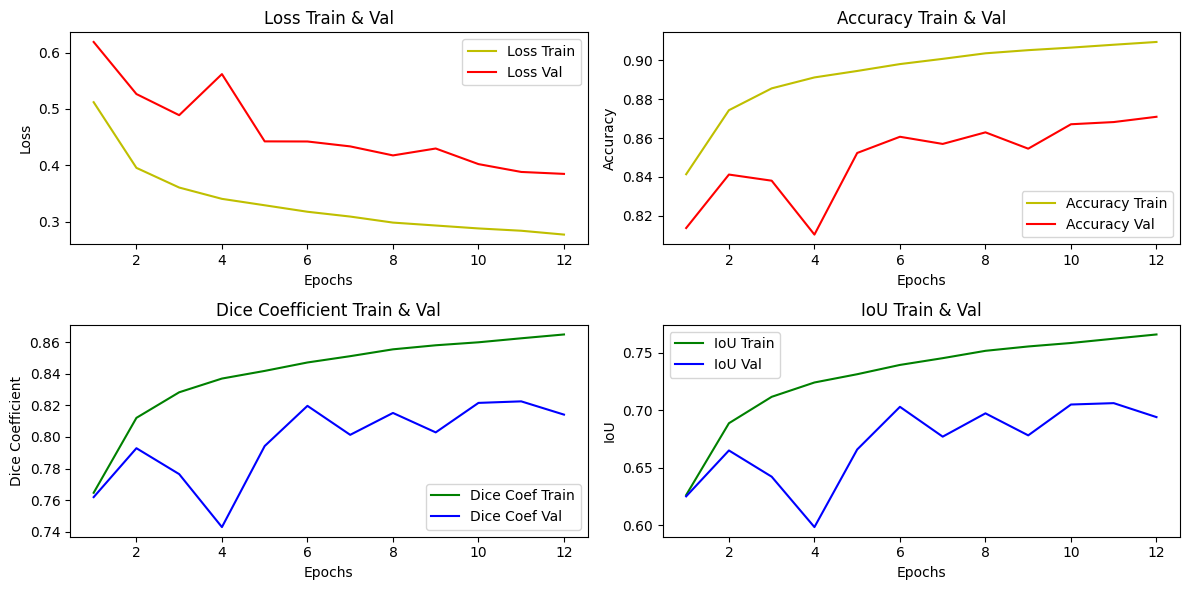

1/1 [==============================] - 0s 267ms/step


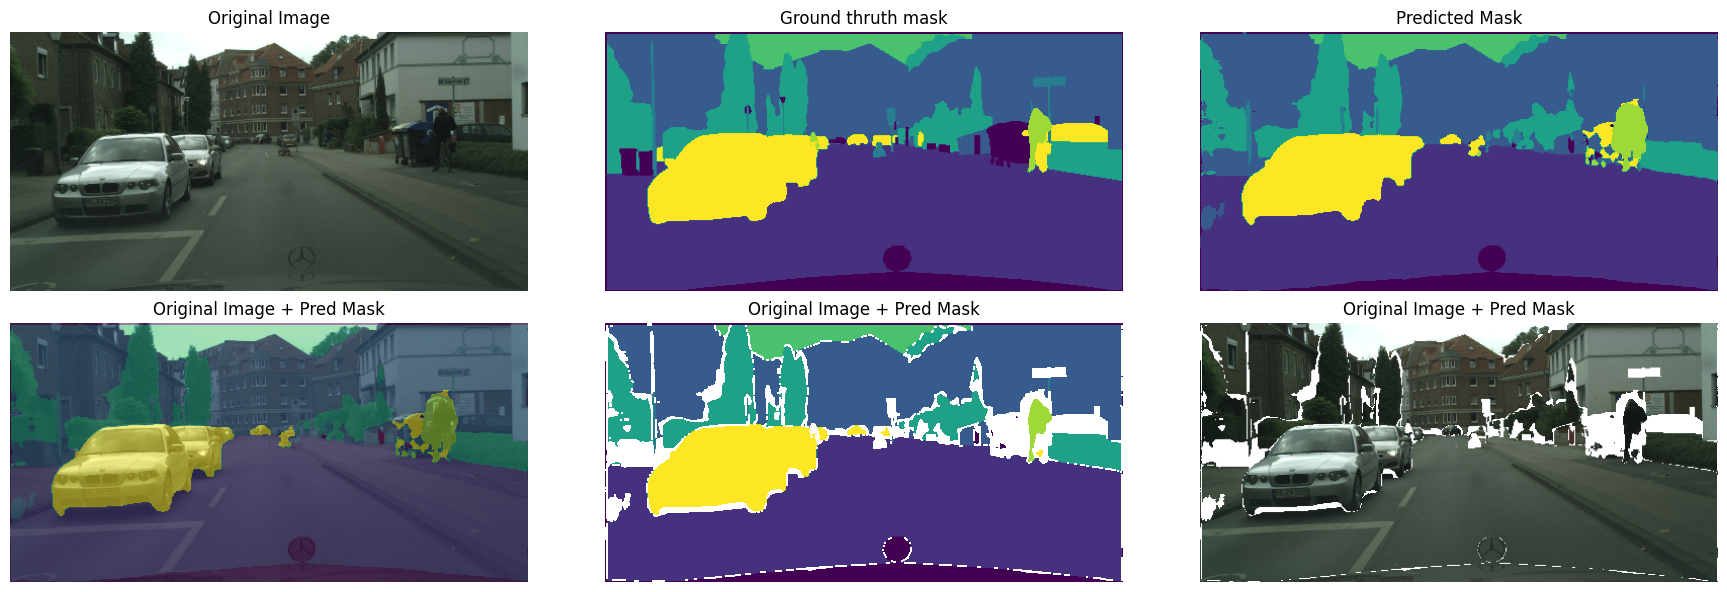

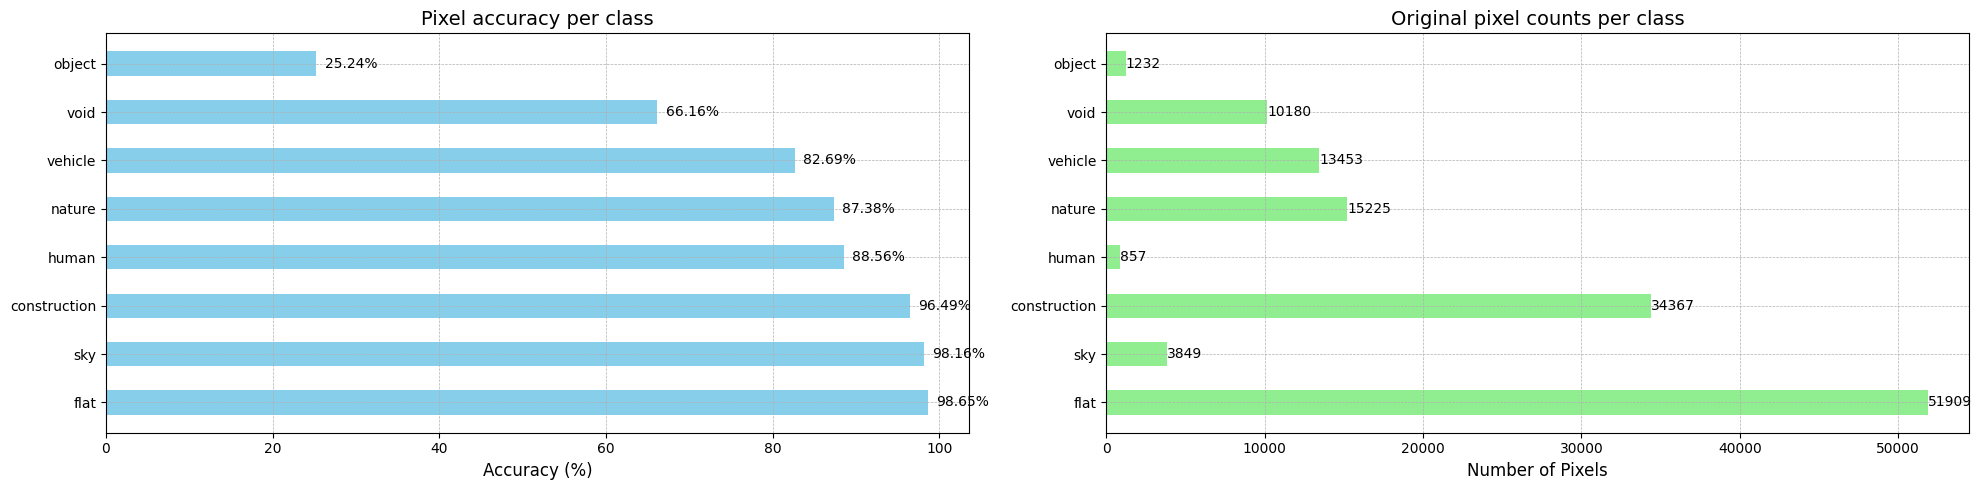

In [13]:
display_loss_accuracy_dice_iou(n_not_aug.model_fit_history)
n_not_aug.model_predict_with_display_and_accuracy(n_not_aug.img["test"][1],n_not_aug.mask["test"][1])

### Performance comparaison augmented vs not

58/58 [==============================] - 21s 357ms/step - loss: 0.2492 - dice_coef: 0.8653 - iou: 0.7652 - accuracy: 0.9203


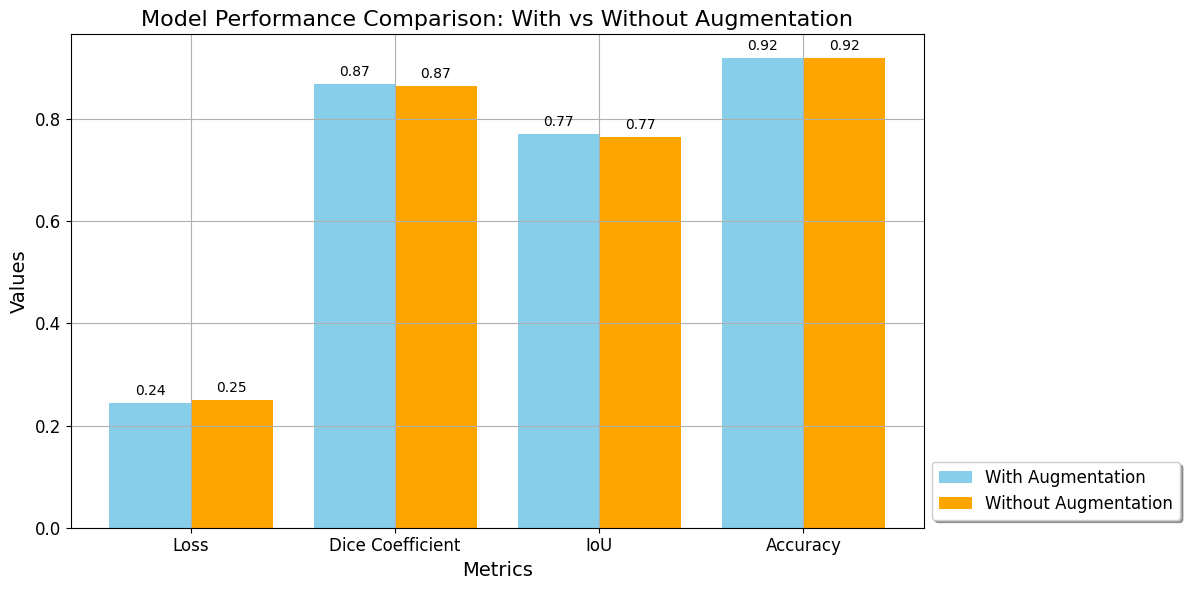

In [14]:
evaluate_with_and_without_aug(n, n_not_aug)

## Model Inference

1/1 [==============================] - 0s 17ms/step


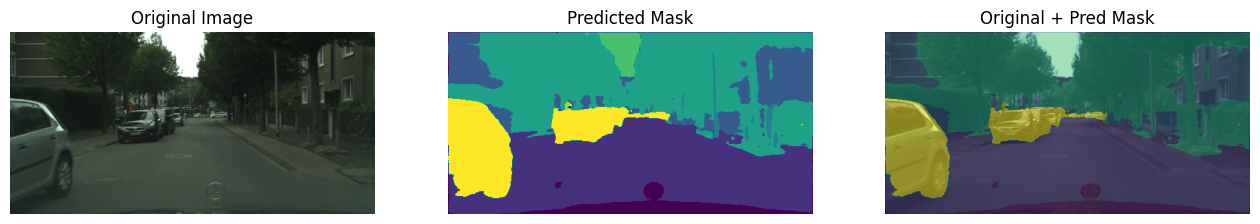

In [15]:
n.model_inference_with_display(n.img["test"][3])

In [ ]:
n_not_aug.model_inference_with_display(n_not_aug.img["test"][3])